#AutoEncoders

##Downloading the dataset

###ML-100K

We will use this dataset 

In [ ]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2021-08-14 13:14:00--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  9.96MB/s    in 0.5s    

2021-08-14 13:14:01 (9.96 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

###ML-1M

In [ ]:
!wget "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip ml-1m.zip
!ls

--2021-08-14 13:14:02--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  10.5MB/s    in 0.5s    

2021-08-14 13:14:03 (10.5 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
ml-100k  ml-100k.zip  ml-1m  ml-1m.zip	sample_data


##Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable #fro stochastic gradient decent
from torchsummary import summary
from tqdm import tqdm  # tqdm is for progress bar


## Importing the dataset


In [ ]:
# We won't be using this dataset.
#this is just to see how is data presented
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

#none as there are no headers
#movie title contains the special characters therefore encoding latin-1


In [ ]:
movies.head()
#movies.info()
ratings.info()
ratings.head()
#userd id, movie id, rating

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   0       1000209 non-null  int64
 1   1       1000209 non-null  int64
 2   2       1000209 non-null  int64
 3   3       1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Preparing the training set and the test set


In [ ]:
# we will be using this data
#base is a training
training_set = pd.read_csv('ml-100k/u1.base',header=None, delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('ml-100k/u1.test',header = None, delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

In [ ]:
training_set

array([[        1,         1,         5, 874965758],
       [        1,         2,         3, 876893171],
       [        1,         3,         4, 878542960],
       ...,
       [      943,      1188,         3, 888640250],
       [      943,      1228,         3, 888640275],
       [      943,      1330,         3, 888692465]])

## Getting the number of users and movies


we need to create an array where we have alll the ows as users and columsn corrresponding to movies and cell corresponding to them will be the rating of the movie i by user j

In [ ]:
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))
print(nb_users, nb_movies)

943 1682


## Converting the data into an array with users in lines and movies in columns


dataset size willl include all the no. of users and movies for both training set and test and we wioll put zero where we dont have data or

In [ ]:
# Creating a matrix where cell u,i is a rating given by user u to the ith movie and if no rating is given put 0 there
data = np.zeros((nb_users, nb_movies))
data.shape


(943, 1682)

In [ ]:
for i in range(len(training_set[:,0])):
  user = training_set[i,0]
  movie = training_set[i,1]
  data[user-1, movie-1]  = training_set[i,2]

In [ ]:
#defining a function out of above for loop

def con(data):
  new_data = np.zeros((nb_users, nb_movies))
  for i in range(len(data[:,0])):
    user = data[i,0]
    movie = data[i,1]
    new_data[user-1, movie-1] = data[i,2]
  return new_data

In [ ]:
new_data = con(training_set)

In [ ]:
t = np.random.rand(3,3)
print(t)
print(t[0][1], t[0,1])

[[0.87318725 0.58930777 0.03518272]
 [0.21414112 0.13476178 0.92699089]
 [0.56616435 0.51015129 0.78331997]]
0.5893077734340606 0.5893077734340606


In [ ]:
print(len(training_set[:,0]))

80000


In [ ]:
training_set = con(training_set)
test_set  = con(test_set)

In [ ]:
for i in range(5):
  print(training_set[i] , test_set[i])

[5. 3. 4. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[4. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.] [4. 3. 0. ... 0. 0. 0.]


## Converting the data into Torch tensors


In [ ]:
training_set = torch.from_numpy(training_set)
test_set = torch.from_numpy(test_set)

In [ ]:
training_set.type()

'torch.DoubleTensor'

In [ ]:
training_set  = training_set.float()
test_set  = test_set.float()

In [ ]:
training_set.type()
test_set.type()

'torch.FloatTensor'

## Creating the architecture of the Neural Network


In [ ]:
# we will build a class
# stacked autoencoder we will use the inheritance
# we will creat a child class form parant class Module adn we will be able to use
#all the funtions and variable from parent class

In [ ]:
class SAE(nn.Module):
  # in heritance is done
  def __init__(self, ):
    super(SAE, self).__init__()
    #we optimize it helps using functionalitiers form parent class
    #to get inherit methods from Modules
    #connection bwtween input and first encoded vector full connection
    self.fc1 = nn.Linear(nb_movies, 20)
    self.fc2 = nn.Linear(20,10)
    self.fc3 = nn.Linear(10,20)
    self.fc4 = nn.Linear(20,nb_movies)
    #specify an activation fucntions
    self.Activation = nn.Sigmoid()

  def forward(self,x):
    x = self.Activation(self.fc1(x))
    x = self.Activation(self.fc2(x))
    x = self.Activation(self.fc3(x))
    x = self.fc4(x) # we dont use activations here
    return x #this is the vector of predicted ratings


In [ ]:
sae=SAE()
criterion = nn.MSELoss()
opt = optim.RMSprop( params = sae.parameters(), lr = 0.01, weight_decay = 0.5 )#weight_decayas regularizes the learning rate after each epoch

In [ ]:
criterion
opt

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0.5
)

In [ ]:
nb_movies

1682

## Training the SAE


In [ ]:
#optimize the code for bigger dataset
epochs = 200
train_loss_list = []
for epoch in range(1, epochs+ 1):
  train_loss = 0
  #excluding the users who did not rate
  s = 0.0 #float
  for id_user in range(nb_users):
    input = training_set[id_user]
    input = Variable(input).unsqueeze(0)#create a new dimenion at 0 index in shape
    target = input.clone()
    #output = sae(input)#additional dimenstion for the batch
    if (torch.sum(input)>0):
       output = sae(input)
       #optimizing memory and computation
       target.require_grad =  False
       output[target == 0] = 0
       loss = criterion(output, target)
       mean_corrector = nb_movies/(float(torch.sum(target.data>0)) + 1e-10)
       loss.backward()#weights will increase or decrease
       train_loss = train_loss + torch.sqrt((loss*mean_corrector))
       s = s + 1.
       opt.step()# by how weight will decrease or increase
  print('Epoch: '+ str(epoch) + " loss : " + str(train_loss/s) )
  train_loss_list.append(train_loss)


  




Epoch: 1 loss : tensor(1.7714, grad_fn=<DivBackward0>)
Epoch: 2 loss : tensor(1.0968, grad_fn=<DivBackward0>)
Epoch: 3 loss : tensor(1.0535, grad_fn=<DivBackward0>)
Epoch: 4 loss : tensor(1.0383, grad_fn=<DivBackward0>)
Epoch: 5 loss : tensor(1.0308, grad_fn=<DivBackward0>)
Epoch: 6 loss : tensor(1.0266, grad_fn=<DivBackward0>)
Epoch: 7 loss : tensor(1.0238, grad_fn=<DivBackward0>)
Epoch: 8 loss : tensor(1.0222, grad_fn=<DivBackward0>)
Epoch: 9 loss : tensor(1.0206, grad_fn=<DivBackward0>)
Epoch: 10 loss : tensor(1.0194, grad_fn=<DivBackward0>)
Epoch: 11 loss : tensor(1.0187, grad_fn=<DivBackward0>)
Epoch: 12 loss : tensor(1.0186, grad_fn=<DivBackward0>)
Epoch: 13 loss : tensor(1.0179, grad_fn=<DivBackward0>)
Epoch: 14 loss : tensor(1.0174, grad_fn=<DivBackward0>)
Epoch: 15 loss : tensor(1.0173, grad_fn=<DivBackward0>)
Epoch: 16 loss : tensor(1.0168, grad_fn=<DivBackward0>)
Epoch: 17 loss : tensor(1.0171, grad_fn=<DivBackward0>)
Epoch: 18 loss : tensor(1.0164, grad_fn=<DivBackward0>)
E

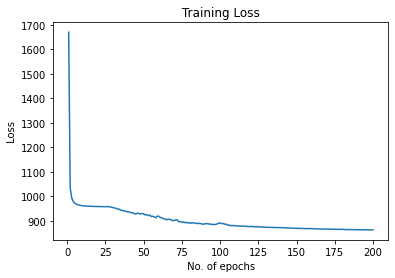

In [ ]:
import matplotlib.pyplot as plt
x = np.array(list(range(1,201, 1)))
plt.plot(x, np.array(train_loss_list))
plt.title(" Training Loss ")
plt.xlabel(" No. of epochs ")
plt.ylabel(" Loss ")
plt.show()

## Testing the SAE


In [ ]:
epochs = 200
train_loss_list = []

test_loss = 0
#excluding the users who did not rate
s = 0.0 #float
for id_user in range(nb_users):
  input = training_set[id_user]
  #here also we will keep it as training_set only as we want to predict the ratings for the movies which user has not watched yet
  #then we will compare this with the data in the test  set as test set has the ratings which are not there in the training set
  input = Variable(input).unsqueeze(0)#create a new dimenion at 0 index in shape
  target = Variable(test_set[id_user].unsqueeze(0))
  #output = sae(input)#additional dimenstion for the batch
  if (torch.sum(input)>0):
      output = sae(input) #these are rating for other movies
      #optimizing memory and computation
      target.require_grad =  False
      output[target == 0] = 0
      loss = criterion(output, target)
      mean_corrector = nb_movies/(float(torch.sum(target.data>0)) + 1e-10)
      test_loss = test_loss + torch.sqrt((loss*mean_corrector))
      s = s + 1.
print(" Test Loss : " + str(test_loss/s) )

 Test Loss : tensor(0.4636, grad_fn=<DivBackward0>)
